# Titanic

In [3]:
import sys
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [23, 10]
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
np.random.seed(122333)

In [5]:
sys.version

'3.6.6 (v3.6.6:4cf1f54eb7, Jun 26 2018, 19:50:54) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

#### Data mining
On commence par miner le dataset pour comprendre ce qu'il contient :

In [6]:
df = pd.read_csv('train.csv')

In [7]:
df.shape

(891, 12)

In [8]:
# Quelles sont nos variables ?
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [9]:
# À quoi ressemble un exemple ?
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Quel est le type des variable ? Quelles infos nous manquent ?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [11]:
# Comment son distribuées les variables quantitatives ?
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
# Quelques infos sur les variables qualitatives :
df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fortune, Mr. Mark",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


Observons les corrélations entre les variables indépendantes et la variable à expliquer :

In [13]:
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [14]:
df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [15]:
df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Jusqu'ici nos observations sont :
- Il semble y avoir une différence significative dans les survies des différentes classes : Pclass serait corrélé avec la survie,
- Les femmes ont définitivement mieux survécu que les hommes.


Étudions plus en profondeur la corrélation âge/survie : la classe âge est "numerical" ainsi un tableau ne saurait la résumer parfaitement (contrairement à "Pclass" qui est ordinal par exemple) :

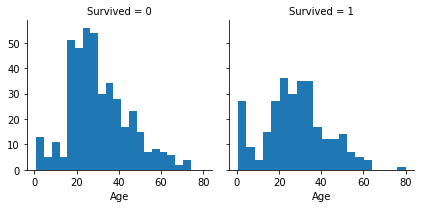

In [16]:
# Âge
fig = sns.FacetGrid(df, col='Survived', size = 3)
fig.map(plt.hist, 'Age', bins=20)

Observations :
- Les enfants de moins de 4 ans ont très bien survécu,
- Les personnes agées de plus de 76 ans également,
- Peu de survie entre 64 et 76 ans,
- La plupart des gens ont entre 16 et 40 ans. Une grande majorité d'entre eux n'a pas survécue.

Croisons Age et Pclass, les deux features semblant les plus déterminantes, et observons les taux de survie :

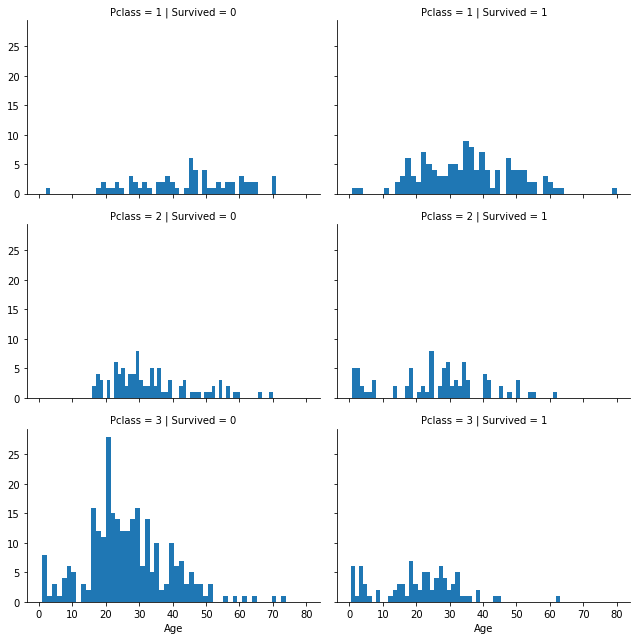

In [17]:
# Pclass
fig = sns.FacetGrid(df, col='Survived', row='Pclass', size=3, aspect=1.5)
fig.map(plt.hist, 'Age', bins=50)

Les distributions ne présentent pas de similitudes, on conjecture que Pclass sera bien une feature déterminante pour les calculs de notre modèle.

Observations :
- Confirmations de certaines de nos hypothèses précédentes : Les enfants < 4 ans ont bien survécu, les très âgés aussi. La classe 3 contient une grande partie des passagers et peu ont survécu, contrairement à la classe 1.

#### Features engineering
Modifions les variables indépendantes pour capturer le plus d'explications !

In [18]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


On a vu que "Cabin" contenait très peu de valeurs non nulles.
Il semble compliqué d'extraire de la valeur de "Ticket". On supprime ces deux features.

In [19]:
df = df.drop(['Ticket', 'Cabin'], axis=1)

On remplace "Sex" par une feature quantitative "Female" = 1 ou 0 si Homme.

In [20]:
df['Female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df = df.drop(['Sex'], axis=1)

On complète les deux valeurs manquantes de la variable "Embarked" en utilisant la valeur la plus fréquente de la variable puis on remplace par des valeurs quantitatives les embarcations :

In [21]:
mode_embarked = df.Embarked.dropna().mode()[0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

La variable "Name" reste à transformer en variable quantitative. Il semble compliqué d'extraire de la valeur des prénoms et noms. En revanche, avec un peu de regex nous allons extraire le titre (Mr., Miss., etc.) qui devrait pouvoir jouer sur la prédiction de la survie.

En effet, on se doute que globalement les gens ayant le mieux survécu sont les femmes aisées. Extraire un titre nous permettra d'affiner nos décisions.

In [22]:
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [23]:
pd.crosstab(df['Title'], df['Female'])

Female,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


Beaucoup de titres existent mais peu sont fréquents. Une façon de gérer cela est de créer une sous-catégorie "Doe" combinant les titres peu fréquents. Ensuite, on rendra numériques ces titres en les associant à des numéros.

In [24]:
df['Title'] = df['Title'].replace(['Capt', 'Col','Countess', 'Don',
                                   'Dr', 'Jonkheer', 'Lady', 'Major',
                                   'Rev', 'Sir'], 'Doe')

df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [25]:
mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Doe': 4}
df['Title'] = df['Title'].map(mapping)
df = df.drop('Name', axis=1)

In [26]:
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Female,Title
0,1,0,3,22.0,1,0,7.2500,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,1,2
2,3,1,3,26.0,0,0,7.9250,0,1,1
3,4,1,1,35.0,1,0,53.1000,0,1,2
4,5,0,3,35.0,0,0,8.0500,0,0,0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null int64
Female         891 non-null int64
Title          891 non-null int64
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


La variable "Age" –déterminante– contient des null. Il nous faut les remplir, et adopter une stratégie pour cela.
L'idée la plus simple serait de remplir les valeurs manquantes par la valeur médiane ou moyenne de "Age". Mais il manque trop de valeurs pour cela et surtout la variable "Age" est trop importante pour que l'on bâcle cette tâche.

On va alors prédire les valeurs manquantes de "Age" grâce aux autre variables indépendantes. Après avoir utilisé des méthodes statistiques (découper le dataset en 'Female' x 'Pclass' puis faire un tirage uniforme dans l'intervalle [mean-std; mean+std] pour chaque zone de ce plan) et ML (régression linéaire de 'Age' à partir de 'Female', 'Pclass' et 'Title' il s'avère que j'obtiens des résultats 35% meilleurs avec le ML au sens du Mean Absolute Error.

Je présente ici l'approche Machine Learning.

In [28]:
age_df = df.dropna()

In [29]:
y = age_df['Age']
X = age_df[['Female','Pclass','Title']]

In [30]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [31]:
reg_lin_xgb = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100,
                               objective='reg:linear', booster='gbtree', n_jobs=1)

In [32]:
reg_lin_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
preds_reg_lin = reg_lin_xgb.predict(X_test)

In [34]:
mean_absolute_error(preds_reg_lin, y_test)

8.818271096236224

On remplace les valeurs null de 'Age' dans le dataset de base :

In [35]:
preds = reg_lin_xgb.predict(df[(df.Age.isnull())][['Female','Pclass','Title']])

In [36]:
df.loc[(df.Age.isnull()),'Age'] = preds

In [37]:
# On coupe les décimales inutiles 
df['Age'] = df['Age'].astype(int)

In [38]:
# On crée une feature produit de Pclass et Age (deux classes très corrélées avec Survie)
# Ce genre d'idée n'est jamais mauvaise.
df['Produit'] = df.Pclass * df.Age

Visualisons les corréalations à ce stade du problème :

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null int64
Female         891 non-null int64
Title          891 non-null int64
Produit        891 non-null int64
dtypes: float64(1), int64(10)
memory usage: 76.6 KB


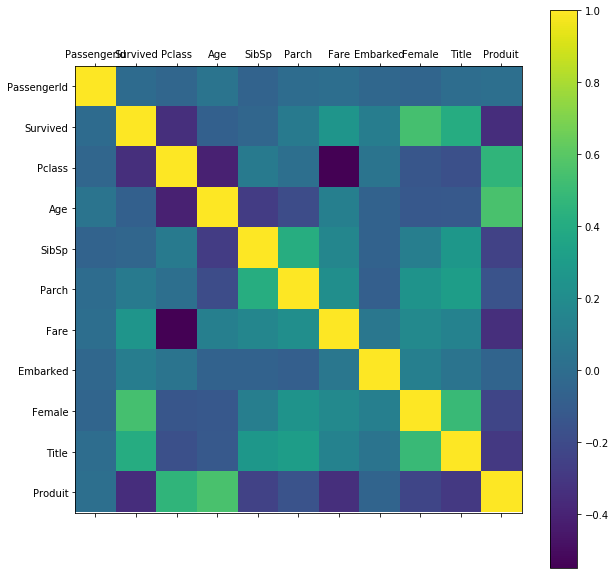

In [40]:
numerical_df = df.select_dtypes(include=['float32','float64','int64'])
plt.matshow(df.corr())
plt.xticks(range(len(numerical_df.columns)), numerical_df.columns)
plt.yticks(range(len(numerical_df.columns)), numerical_df.columns)
plt.colorbar()
plt.show()

#### Model building

In [41]:
y = df['Survived']
X = df.drop(['Survived'], axis=1).copy()

In [42]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

82.3

In [44]:
coeff_df = pd.DataFrame(df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
7,Female,2.200306
8,Title,0.518539
6,Embarked,0.193887
5,Fare,0.005935
0,Survived,-0.000033
9,Produit,-0.010448
2,Age,-0.019437
4,Parch,-0.214135
3,SibSp,-0.474980
1,Pclass,-0.699144


In [45]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

100.0

In [46]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

81.18

In [47]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

100.0

In [48]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked,Female,Title,Produit
804,805,3,27,0,0,6.9750,0,0,0,81
700,701,1,18,1,0,227.5250,1,1,2,18
465,466,3,38,0,0,7.0500,0,0,0,114
644,645,3,0,2,1,19.2583,1,1,1,0
796,797,1,49,0,0,25.9292,0,1,4,49
633,634,1,41,0,0,0.0000,0,0,0,41
392,393,3,28,2,0,7.9250,0,0,0,84
254,255,3,41,0,2,20.2125,0,1,2,123
303,304,2,22,0,0,12.3500,2,1,1,44
166,167,1,39,0,1,55.0000,0,1,2,39


### Conclusion

Le problème était ici relativement classique, et "l'artillerie lourde" n'a pas eu besoin d'être déployée. J'entends par là les tests statistiques pour l'importance des variables, leur décorrélation (PCA), la régularisation du modèle, le feature engineering complexe ou encore les modèles ensemblistes exotiques.

Il s'agissait d'un problème de classification binaire. Nos modèles nous prédisent une probabilité (ou une sorte de probabilité). Dans un problème de classification complexe (ex : analyse médicales pour la détection de cellules cancéreuses) plusieurs problématiques se posent quant au score observé. J'ai ici utilisé l'accuracy par défaut, mais tout un tas de score pourraient être observés : le score AUC de la courbe ROC pour optimiser le threshold de décision, la précision, le recall, le score F1... Tout dépend de l'importance accordée aux erreurs de type 1 et 2.

La méthode que j'ai employée ici pourrait s'appliquer à divers problèmes de marketing. Par exemple, un calcul de churn d'un utilisateur en fonction de l'historique de ses logs, des ses achats et de ses caractéristiques pourrait suivre le même déroulement. Ou encore, un calcul de probabilité de clic sur une publicité en fonction du comportement de l'utilisateur, de sa situation géographique et de l'heure.